## Mini Exploration - Calculating Complex Power

Lets calculate complex power at multiple points in time using the sunshine data. You can read more about the sunshine dataset on the blog [here](https://blog.ni4ai.org/post/2020-03-30-sunshine-data/). You can find a diagram with approximate sensor locations [here](https://blog.ni4ai.org/post/2021-05-29-disaggregation/). [This blog post](https://blog.ni4ai.org/post/2021-06-19-power_factor/) introduces what *complex power* is, and of course you can find out more on wikipedia. Another relevant topic is the meaning of phasors which is introduced [here](https://blog.ni4ai.org/post/2020-07-30-what-is-the-angle/). 

The basic calculation is as follows: $S = VI^*$
 [in this equation all three quantities are phasors represented as complex]. The data streams we will use here seperately record the magnitude and angle of phasors. These are the outputs generated by _Phasor Measurement Units_ or PMUs. A phasor can be represented as a magnitude and angle but it can also be written as the sum of a real and imaginary part, ie a complex number. We can convert between the two notations using Euler’s formula.
 

Functions/objects used here:
```
btrdb.connect()
numpy.unwrap()
btrdb.streams.StreamSet
btrdb.streams.StreamSet.earliest()
btrdb.streams.StreamSet.latest()
btrdb.streams.StreamSet.values()
btrdb.point.RawPoint
```

# Imports

In [29]:
import pandas as pd
import btrdb
import numpy as np
import re
from btrdb.utils.timez import *
from tabulate import tabulate
from pprint import pprint
from typing import List, Tuple
from matplotlib import pyplot as plt

In [51]:
# A figure size to use throughout for plotting
figsize = (10, 5)

# Connect To Server
To get started we'll connect to the server and define a helper method to describe our `btrdb.Stream`s.

In [30]:
connection = btrdb.connect()
pprint(connection.info())

{'build': '5.17.4', 'majorVersion': 5, 'proxy': {'proxyEndpoints': []}}


In [31]:
# add a helper method to describe streams from streamset tutorial notebook 3
def describe_streams(streams: btrdb.stream.StreamSet):
    table = [["Collection", "Name", "Units", "Version", "Earliest", "Latest"]]
    for stream in streams:
        tags = stream.tags()
        table.append(
            [
                stream.collection,
                stream.name,
                tags["unit"],
                stream.version(),
                stream.earliest()[0].time,
                stream.latest()[0].time,
            ]
        )
    return tabulate(table, headers="firstrow")

Lets take a look at the [sunshine data set again](https://blog.ni4ai.org/post/2020-03-30-sunshine-data/).

In [32]:
sunshine_collection = connection.list_collections("sunshine")
pprint(sunshine_collection)

['sunshine/PMU1',
 'sunshine/PMU2',
 'sunshine/PMU3',
 'sunshine/PMU4',
 'sunshine/PMU5',
 'sunshine/PMU6']


Each of these collections correspond to the data streams generated by a single PMU. For the complex power calculations, let's first look at a single collection in this list; in this case, `PMU1`.

In [33]:
pmu1 = connection.streams_in_collection(sunshine_collection[0])
print(describe_streams(pmu1))

Collection     Name    Units      Version             Earliest               Latest
-------------  ------  -------  ---------  -------------------  -------------------
sunshine/PMU1  LSTATE  mask        243640  1443715704008333000  1492220199333333000
sunshine/PMU1  C1ANG   deg         240607  1443715704008333000  1492220199333333000
sunshine/PMU1  C3MAG   amps        240481  1443715704008333000  1492220199333333000
sunshine/PMU1  C2MAG   amps        240718  1443715704008333000  1492220199333333000
sunshine/PMU1  C1MAG   amps        240380  1443715704008333000  1492220495999999000
sunshine/PMU1  C3ANG   deg         240781  1443715704008333000  1492220199333333000
sunshine/PMU1  L3ANG   deg         240862  1443715704008333000  1492220495999999000
sunshine/PMU1  L2ANG   deg         240662  1443715704008333000  1492220495999999000
sunshine/PMU1  L3MAG   volts       229263  1443715704008333000  1492220495999999000
sunshine/PMU1  L1ANG   deg         229265  1443715704008333000  149222037599

`StreamSet`s provide us with a nice way to operate on many `Stream`s at once. Lets collect the streams of `pmu1` into a single `StreamSet`

In [34]:
pmu1_streamset = btrdb.stream.StreamSet(pmu1)
pprint(pmu1_streamset)

<StreamSet(13 streams)>


StreamSets are iterable objects, so our `describe_streams` method works on them too!

In [35]:
print(describe_streams(pmu1_streamset))

Collection     Name    Units      Version             Earliest               Latest
-------------  ------  -------  ---------  -------------------  -------------------
sunshine/PMU1  LSTATE  mask        243640  1443715704008333000  1492220199333333000
sunshine/PMU1  C1ANG   deg         240607  1443715704008333000  1492220199333333000
sunshine/PMU1  C3MAG   amps        240481  1443715704008333000  1492220199333333000
sunshine/PMU1  C2MAG   amps        240718  1443715704008333000  1492220199333333000
sunshine/PMU1  C1MAG   amps        240380  1443715704008333000  1492220495999999000
sunshine/PMU1  C3ANG   deg         240781  1443715704008333000  1492220199333333000
sunshine/PMU1  L3ANG   deg         240862  1443715704008333000  1492220495999999000
sunshine/PMU1  L2ANG   deg         240662  1443715704008333000  1492220495999999000
sunshine/PMU1  L3MAG   volts       229263  1443715704008333000  1492220495999999000
sunshine/PMU1  L1ANG   deg         229265  1443715704008333000  149222037599

Lets take a look at when the last data point was added to each `Stream` using the `latest()` method. 

In [36]:
# when was the latest datapoint added?
btrdb.utils.timez.ns_to_datetime(pmu1_streamset[0].latest()[0][0])

datetime.datetime(2017, 4, 15, 1, 36, 39, 333333, tzinfo=<UTC>)

# Viewing Data

Like the `Stream` object, the `StreamSet` has a `values` method which will return a list of lists.  Each internal list contains the `RawPoint` instances for a given stream.

---

Lets add a helper method to take a `RawPoint` and return the time value from it in nanoseconds

In [37]:
def ns_from_rawpoint(point: btrdb.point.RawPoint) -> int:
    """Automatically take a rawpoint and return the time value (in ns)
    when the data was added."""

    return point[0][0]

One more helper method to parse `RawPoint`s and convert them into numpy arrays, since we will be using these values a lot.

In [38]:
def values_to_arr(values: Tuple[btrdb.stream.RawPoint]) -> np.array:
    "Convert a tuple of RawPoints into a numpy array of time, value pairs."
    return np.asarray([[time, val] for time, val in values])

To make things a bit simpler, we know that PMU devices excel in time-synchronized data, so we will take a few liberties in data valdiation and assume that the `RawPoint` lists we obtain from our streamset are identically sized (and time-aligned) for each stream.

When was the latest data point added to each stream in sunshine/PMU1 collection?

In [39]:
last_time_updated = []
for stream in pmu1_streamset:
    tmp_point = stream.latest()
    last_time_updated.append(
        [stream.tags().get("name", "N/A"), ns_from_rawpoint(tmp_point)]
    )
for val in last_time_updated:
    print(f"Stream: {val[0]}\t Last Updated: {ns_to_datetime(val[1])}")

Stream: LSTATE	 Last Updated: 2017-04-15 01:36:39.333333+00:00
Stream: C1ANG	 Last Updated: 2017-04-15 01:36:39.333333+00:00
Stream: C3MAG	 Last Updated: 2017-04-15 01:36:39.333333+00:00
Stream: C2MAG	 Last Updated: 2017-04-15 01:36:39.333333+00:00
Stream: C1MAG	 Last Updated: 2017-04-15 01:41:35.999999+00:00
Stream: C3ANG	 Last Updated: 2017-04-15 01:36:39.333333+00:00
Stream: L3ANG	 Last Updated: 2017-04-15 01:41:35.999999+00:00
Stream: L2ANG	 Last Updated: 2017-04-15 01:41:35.999999+00:00
Stream: L3MAG	 Last Updated: 2017-04-15 01:41:35.999999+00:00
Stream: L1ANG	 Last Updated: 2017-04-15 01:39:35.999999+00:00
Stream: C2ANG	 Last Updated: 2017-04-15 01:36:39.333333+00:00
Stream: L1MAG	 Last Updated: 2017-04-15 01:37:11.333333+00:00
Stream: L2MAG	 Last Updated: 2017-04-15 01:41:35.999999+00:00


Here is an equivalent way to do the same as above, but using a `StreamSet` method.

In [40]:
for stream, time in zip(pmu1_streamset, pmu1_streamset.latest()):
    print(
        f"Stream: {stream.tags().get('name')}\t Last Updated: {ns_to_datetime(time.time)}"
    )

Stream: LSTATE	 Last Updated: 2017-04-15 01:36:39.333333+00:00
Stream: C1ANG	 Last Updated: 2017-04-15 01:36:39.333333+00:00
Stream: C3MAG	 Last Updated: 2017-04-15 01:36:39.333333+00:00
Stream: C2MAG	 Last Updated: 2017-04-15 01:36:39.333333+00:00
Stream: C1MAG	 Last Updated: 2017-04-15 01:41:35.999999+00:00
Stream: C3ANG	 Last Updated: 2017-04-15 01:36:39.333333+00:00
Stream: L3ANG	 Last Updated: 2017-04-15 01:41:35.999999+00:00
Stream: L2ANG	 Last Updated: 2017-04-15 01:41:35.999999+00:00
Stream: L3MAG	 Last Updated: 2017-04-15 01:41:35.999999+00:00
Stream: L1ANG	 Last Updated: 2017-04-15 01:39:35.999999+00:00
Stream: C2ANG	 Last Updated: 2017-04-15 01:36:39.333333+00:00
Stream: L1MAG	 Last Updated: 2017-04-15 01:37:11.333333+00:00
Stream: L2MAG	 Last Updated: 2017-04-15 01:41:35.999999+00:00


Lets find the latest starting time (in ns) across all the streams and use this as the starting point of our power calculation. We then choose the end time for our power calculation to be 100 seconds later. Next let's query all values between the chosen start and end times.

In [41]:
start_time_arr = values_to_arr(pmu1_streamset.earliest())

start = np.max(start_time_arr[:, 0])
end = start + ns_delta(seconds=100)
print(start)
print(end)

print(f"our bounding start time will be: {btrdb.utils.timez.ns_to_datetime(start)}")
print(f"our end time will be: {btrdb.utils.timez.ns_to_datetime(end)}")

1.443715704008333e+18
1.443715804008333e+18
our bounding start time will be: 2015-10-01 16:08:24.008333+00:00
our end time will be: 2015-10-01 16:10:04.008333+00:00


# Complex Power

These PMU data streams are exactly what we need to calculate the instantaneous power.

To calculate this, lets look again at the equation for instantaneous power:
The basic equation is as follows: $S = VI^*$

Our voltage $V$ is a phasor represented as a complex number by a magnitude and an angle (or equivalently a real and imaginary component). The voltage magnitudes are recorded in streams `L1MAG` to `L3MAG` and the angles in `L1ANG` to `L3ANG`. The same is true for the current $I$, with current magnitudes and angles recorded in streams `C1MAG` to `C3MAG` and `C1ANG` to `C3ANG` respectively. We have three streams for each quantity because the PMU reports on all three phases.


# Filtering StreamSets

Since we know that the voltage and current streams in our stream set each have their corresponding angles and magnitudes, lets group these into more logical `StreamSet`s by filtering these such that all of our current and voltage related streams are grouped together. We can use regex matching to do some advanced filtering.

In [42]:
pmu1_c = pmu1_streamset.filter(name=re.compile("C[\d]"))
pmu1_l = pmu1_streamset.filter(name=re.compile("L[\d]"))

print(describe_streams(pmu1_c))
print()
print(describe_streams(pmu1_l))

Collection     Name    Units      Version             Earliest               Latest
-------------  ------  -------  ---------  -------------------  -------------------
sunshine/PMU1  C1ANG   deg         240607  1443715704008333000  1492220199333333000
sunshine/PMU1  C3MAG   amps        240481  1443715704008333000  1492220199333333000
sunshine/PMU1  C2MAG   amps        240718  1443715704008333000  1492220199333333000
sunshine/PMU1  C1MAG   amps        240380  1443715704008333000  1492220495999999000
sunshine/PMU1  C3ANG   deg         240781  1443715704008333000  1492220199333333000
sunshine/PMU1  C2ANG   deg         229263  1443715704008333000  1492220199333333000

Collection     Name    Units      Version             Earliest               Latest
-------------  ------  -------  ---------  -------------------  -------------------
sunshine/PMU1  L3ANG   deg         240862  1443715704008333000  1492220495999999000
sunshine/PMU1  L2ANG   deg         240662  1443715704008333000  14922204959

Lets take these `StreamSet`s and and convert the range of values we want to `pandas.DataFrame`s

<AxesSubplot:xlabel='time'>

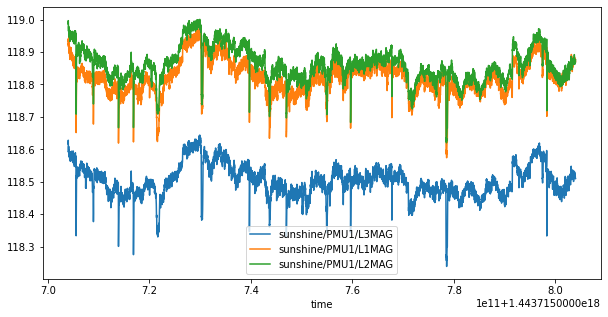

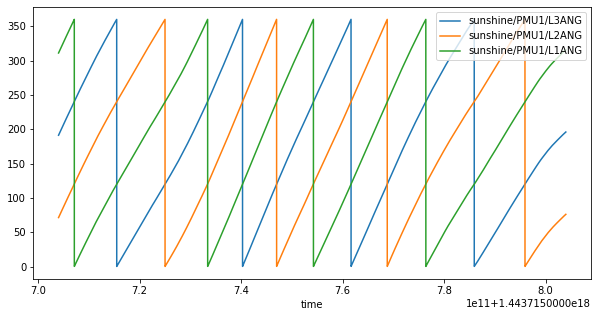

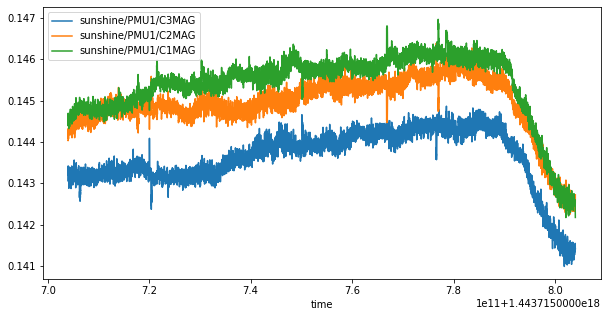

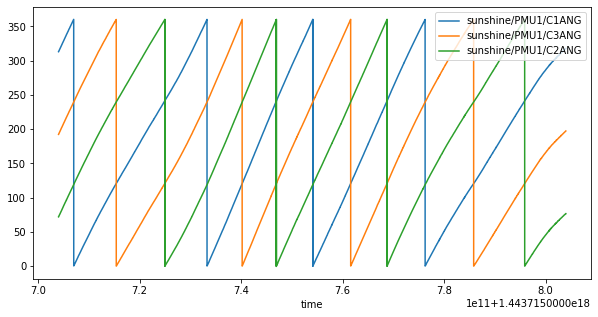

In [60]:
pmu1_voltage_df = pmu1_l.filter(start=start, end=end).to_dataframe()
pmu1_current_df = pmu1_c.filter(start=start, end=end).to_dataframe()

pmu1_voltage_df[pmu1_voltage_df.filter(like='MAG').columns].plot(figsize=figsize)
pmu1_voltage_df[pmu1_voltage_df.filter(like='ANG').columns].plot(figsize=figsize)
pmu1_current_df[pmu1_current_df.filter(like='MAG').columns].plot(figsize=figsize)
pmu1_current_df[pmu1_current_df.filter(like='ANG').columns].plot(figsize=figsize)

Lets convert our magnitude and angles to their complex forms for each combination of streams, appending the results to the same dataframe. 

**Remember** that we also need to unwrap the angles and convert them to radians.

In [62]:
prefix = "sunshine/PMU1/"
mag = "MAG"
ang = "ANG"
for i in range(1, int(len(pmu1_c) / 2) + 1):
    # convert to radians and unwrap the angles
    pmu1_current_df[f"{prefix}C{i}{ang}"] = np.unwrap(
        np.deg2rad(pmu1_current_df[f"{prefix}C{i}{ang}"][:])
    )
    pmu1_current_df[f"{prefix}{i}_complex_current"] = pmu1_current_df[
        f"{prefix}C{i}{mag}"
    ] * np.exp(1j * pmu1_current_df[f"{prefix}C{i}{ang}"])
pmu1_current_df

,sunshine/PMU1/C1ANG,sunshine/PMU1/C3MAG,sunshine/PMU1/C2MAG,sunshine/PMU1/C1MAG,sunshine/PMU1/C3ANG,sunshine/PMU1/C2ANG,sunshine/PMU1/1_complex_current,sunshine/PMU1/2_complex_current,sunshine/PMU1/3_complex_current
time,,,,,,,,,
1443715704016666000,5.463350,0.143241,0.144034,0.144479,3.358112,1.257007,0.098584-0.105619j,0.044458+0.137001j,-0.139897-0.030773j
1443715704024999000,5.464112,0.143202,0.144030,0.144401,3.358837,1.257461,0.098611-0.105487j,0.044395+0.137017j,-0.139836-0.030866j
1443715704033333000,5.466496,0.143307,0.144093,0.144516,3.360621,1.259578,0.098941-0.105335j,0.044124+0.137171j,-0.139884-0.031138j
1443715704041666000,5.471296,0.143419,0.144258,0.144693,3.365864,1.265048,0.099568-0.104988j,0.043423+0.137567j,-0.139827-0.031896j
1443715704049999000,5.475001,0.143242,0.144323,0.144579,3.371314,1.269856,0.099877-0.104536j,0.042780+0.137837j,-0.139479-0.032617j
...,...,...,...,...,...,...,...,...,...
1443715803974999000,30.674377,0.141435,0.142552,0.142488,28.570723,26.469592,0.105074-0.096241j,0.033046+0.138668j,-0.135268-0.041309j
1443715803983333000,30.676065,0.141480,0.142612,0.142429,28.572632,26.471152,0.105192-0.096023j,0.032844+0.138779j,-0.135232-0.041580j
1443715803991666000,30.678736,0.141545,0.142504,0.142421,28.574040,26.472695,0.105442-0.095737j,0.032605+0.138724j,-0.135235-0.041790j


In [63]:
for i in range(1, int(len(pmu1_voltage_df.columns) / 2) + 1):
    # convert to radians and unwrap the angles
    pmu1_voltage_df[f"{prefix}L{i}{ang}"] = np.unwrap(
        np.deg2rad(pmu1_voltage_df[f"{prefix}L{i}{ang}"][:])
    )
    pmu1_voltage_df[f"{prefix}{i}_complex_voltage"] = pmu1_voltage_df[
        f"{prefix}L{i}{mag}"
    ] * np.exp(1j * pmu1_voltage_df[f"{prefix}L{i}{ang}"])
display(pmu1_voltage_df)

,sunshine/PMU1/L3ANG,sunshine/PMU1/L2ANG,sunshine/PMU1/L3MAG,sunshine/PMU1/L1ANG,sunshine/PMU1/L1MAG,sunshine/PMU1/L2MAG,sunshine/PMU1/1_complex_voltage,sunshine/PMU1/2_complex_voltage,sunshine/PMU1/3_complex_voltage
time,,,,,,,,,
1443715704016666000,3.338624,1.244940,118.616264,5.429859,118.932671,118.986610,78.195957-89.612345j,38.090037+112.725164j,-116.321270-23.220257j
1443715704024999000,3.340895,1.247206,118.621452,5.432106,118.939789,118.992485,78.401779-89.441794j,37.836363+112.816759j,-116.273344-23.485282j
1443715704033333000,3.343286,1.249564,118.627998,5.434513,118.940865,118.996712,78.617546-89.253632j,37.571575+112.909673j,-116.223253-23.764627j
1443715704041666000,3.345673,1.251970,118.611221,5.436899,118.928505,118.984383,78.822059-89.056568j,37.295937+112.988036j,-116.149767-24.038583j
1443715704049999000,3.347872,1.254229,118.592003,5.439086,118.917343,118.969002,79.009267-88.875588j,37.035766+113.057399j,-116.077821-24.289967j
...,...,...,...,...,...,...,...,...,...
1443715803974999000,28.549321,26.456104,118.513542,30.640921,118.873047,118.868683,84.924908-83.177889j,29.112909+115.248437j,-114.060843-32.180487j
1443715803983333000,28.550324,26.457090,118.512428,30.641896,118.872719,118.866943,85.005752-83.094798j,28.998877+115.275389j,-114.027422-32.294625j
1443715803991666000,28.551361,26.458075,118.511482,30.642885,118.868408,118.867134,85.084858-83.007622j,28.88529+0115.304100j,-113.992960-32.412599j


Lets calculate the complex power for each of the 3 sets of stream data we just created.

In [64]:
col_list = [
    "sunshine/PMU1/1_complex_",
    "sunshine/PMU1/2_complex_",
    "sunshine/PMU1/3_complex_",
]
power_list = []
for col in col_list:
    power_list.append(
        pmu1_voltage_df[f"{col}voltage"][:]
        * np.conjugate(pmu1_current_df[f"{col}current"])
    )

Lets visualize these using `matplotlib.pyplot` - We will look at the magnitude of the complex power, denoted $|S|$. 

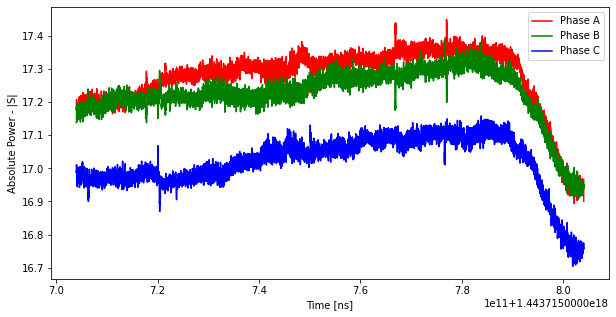

In [74]:
plt.figure(figsize=figsize)
plt.plot(np.abs(power_list[0]), color='red', label='Phase A')
plt.plot(np.abs(power_list[1]), color='green', label='Phase B')
plt.plot(np.abs(power_list[2]), color='blue', label='Phase C')

plt.xlabel("Time [ns]")
plt.ylabel("Absolute Power - |S|")
plt.legend()

Finally, we can decompose the complex power into its real and imaginary parts, termed the _real_ and _reactive_ power and denoted $P$ and $Q$ respectively. Let's visualize those. 

Text(0, 0.5, 'Reactive Power - Q')

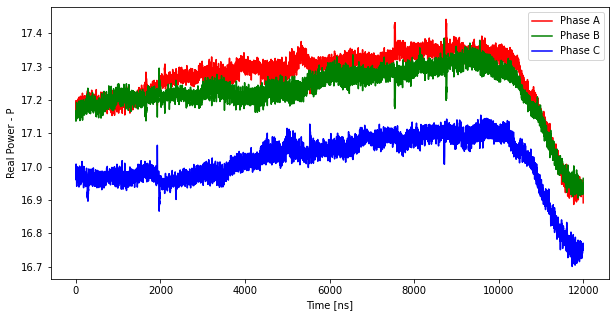

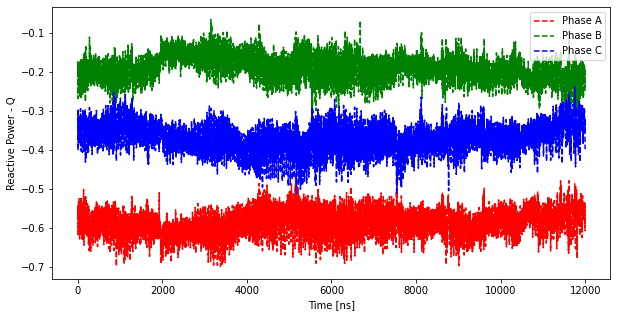

In [75]:
plt.figure(figsize=figsize)
# Real Power - P
plt.plot(np.real(power_list[0]), color='red', label='Phase A')
plt.plot(np.real(power_list[1]), color='green', label='Phase B')
plt.plot(np.real(power_list[2]), color='blue', label='Phase C')
plt.legend()

plt.xlabel("Time [ns]")
plt.ylabel("Real Power - P")

plt.figure(figsize=figsize)
# Reactive Power - Q
plt.plot(np.imag(power_list[0]), color='red', linestyle='--', label='Phase A')
plt.plot(np.imag(power_list[1]), color='green', linestyle='--', label='Phase B')
plt.plot(np.imag(power_list[2]), color='blue', linestyle='--', label='Phase C')
plt.legend()

plt.xlabel("Time [ns]")
plt.ylabel("Reactive Power - Q")

The power flow measured at this PMU is dominated by real power! 